# Low Rank Matrix Factorization

## Formulation
Let's assume that our system has $I_{user}$ users and $J_{movie}$ movies. We assign $K_{latent}$ features to each user and movie in the system. We can construct a matrix factorization as follows:

$$
\begin{vmatrix}
x_{0,0} & x_{0,1} & x_{0, 2} & ... & x_{0, K} \\
x_{1,0} & ...     & ...      & ... & ...      \\
x_{2,0} & ...     & ...      & ... & ...      \\
...     & ...     & ...      & ... & ...      \\
x_{I,0} & ...     & ...      & ... & x_{I, K}
\end{vmatrix}
\begin{vmatrix}
\theta_{0,0} & \theta_{0,1} & \theta_{0, 2} & ... & \theta_{0, K} \\
\theta_{1,0} & ...     & ...      & ... & ...      \\
\theta_{2,0} & ...     & ...      & ... & ...      \\
...     & ...     & ...      & ... & ...      \\
\theta_{J,0} & ...     & ...      & ... & \theta_{J, K}
\end{vmatrix}^{T}
=
\begin{vmatrix}
r_{0,0} & r_{0,1} & r_{0, 2} & ... & r_{0, J} \\
r_{1,0} & ...     & ...      & ... & ...      \\
r_{2,0} & ...     & ...      & ... & ...      \\
...     & ...     & ...      & ... & ...      \\
r_{I,0} & ...     & ...      & ... & r_{I, J}
\end{vmatrix}
$$

$X$ represents the latent feature matrix for all users in our system. $\Theta$ represents the latent feature matrix for all movies in our system. The matrix product of $X$ and $\Theta^{T}$ is the model predicated rating. 

$$
X\Theta^{T} = \hat{R}
$$

Let $R$ represents the actual rating we received from the MovieLens dataset. For every missing value in $R$, we will ignore their contribution to the loss function. Then for every `R[i][j] != nil`, we define the loss function as follows:

$$
L_{X, \Theta} = \frac{1}{2}\Sigma_{i,j} (X\Theta^{T} - R)^{2} + \frac{\lambda}{2}\Sigma_{i, k}X^{2} + \frac{\lambda}{2}\Sigma_{j, k}\Theta^{2}
$$

The optimization objective here is to minimize the loss function above. Notice that I have omitted bias terms in here. I've noticed that biases are in general not necessary for matrix factorization. The simultaneous update of user and movie latent vectors will compensate and account for the needed bias. I may be wrong, since I haven't actually written down the math to prove that is the case.

## Partial Derivatives & Gradients

### Iterative Approach
For a given user `i`, and he/she has a preference vector of size `K`, iterate from `k=0` to `k=K` and update each element of his preference vector using the following gradient calculation:
$$
\frac{\partial L}{\partial x_{i, k}} = \sum_{j}^{J} (R_{i, j} - \hat{R}_{i, j})\cdot \theta_{j, k} + \lambda x_{i, k}
$$

For a given movie `j`, and it has a feature vector of size `K`, iterate from `k=0` to `k=K` and update each element of its feature vector using the following gradient calculation:
$$
\frac{\partial L}{\partial \theta_{j, k}} = \sum_{i}^{I} (R_{i, j} - \hat{R}_{i, j})\cdot x_{i, k} + \lambda \theta_{j, k}
$$

Remember that 
$$
\hat{R}_{i, j} = \vec{x_{i}} \cdot \vec{\theta_{j}}
$$
 
### Vectorized Approach

Recall that the output of our low-rank matrices model is $\hat{R}$ and let's find the gradient of $L$ with respect to $\hat{R}$ first. The $\frac{1}{2}$ term will get canceled out by the square term.

$$
\frac{\partial L}{\partial \hat{R}} = \hat{R} - R
$$

$$
\hat{R} = X\Theta^{T}
$$

Now let's figure out the gradient of $\hat{R}$ with respect to $X$ and $\Theta$:

$$
\frac{\partial \hat{R}}{\partial X} = \Theta^{T}
$$

$$
\frac{\partial \hat{R}}{\partial \Theta} = X
$$

Using chain rule, we can then derive the following results:

$$
\frac{\partial L}{\partial X} = \frac{\partial L}{\partial \hat{R}}\frac{\partial \hat{R}}{\partial X}
$$

$$
\frac{\partial L}{\partial \Theta} = \frac{\partial L}{\partial \hat{R}}\frac{\partial \hat{R}}{\partial \Theta}
$$

An example implemented using `numpy`. We set gradient of model prediction output to zero if that particular entry is missing in the training rating matrix. It is simply saying we are ignoring nil entries' contribution to the loss function. We use zero to represent nil entries in the training `R` matrix.
```python
grad_pred = np.dot(self.U, self.M.T) - self.R
grad_pred[self.R == 0] = 0
grad_u = np.dot(grad_pred, self.M) + (self.reg * self.U)
grad_m = np.dot(grad_pred.T, self.U) + (self.reg * self.M)
```

### Caution
In general vectorized approach is much faster than iterative approach but there is a huge memory constraint. When you run 260,000 users on 45,000 movies, the matrix size is 11,700,000,000 and assuming each matrix entry is a float64. That means it's taking up 93,600,000,000 bytes in memory for just one single matrix. I am pretty sure you don't have a machine that has 100+ GB in RAM. Thus, depending on dataset size, it is sometimes better to write an iterative approach using a static typed performant language (C, C++, Go, or Java/Scala.) 

### Implementation Details
Please look at the `lowrank` module inside this folder to find out more about the implementation details.

## Gradient Check
Let's confirm that gradients are computed correctly first.

In [1]:
import lowrank
import numpy as np

np.random.seed(0)
rand_training_mat = np.random.rand(5, 5)

# Randomly remove certain values to make the matrix sparse
rand_training_mat[rand_training_mat < 0.50] = 0 

# Pick out some set of values from the training set to be test set and then remove those values from training set
rand_test_mat = np.copy(rand_training_mat)
rand_test_mat[rand_training_mat < 0.90] = 0 
rand_training_mat[rand_test_mat != 0] = 0

print 'Randomly initialized training sparse matrix'
print rand_training_mat

print 'Randomly initialized test sparse matrix'
print rand_test_mat

factorizer = lowrank.Factorizer(rand_training_mat, rand_test_mat, feature_dim=3)

Randomly initialized training sparse matrix
[[0.5488135  0.71518937 0.60276338 0.54488318 0.        ]
 [0.64589411 0.         0.891773   0.         0.        ]
 [0.79172504 0.52889492 0.56804456 0.         0.        ]
 [0.         0.         0.83261985 0.77815675 0.87001215]
 [0.         0.79915856 0.         0.78052918 0.        ]]
Randomly initialized test sparse matrix
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.96366276 0.        ]
 [0.         0.         0.         0.92559664 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.97861834 0.         0.         0.         0.        ]]
Factorizer is instantiated with U: (5, 3) and M: (5, 3)


In [2]:
grad_u, grad_m = factorizer.gradients()
num_grad_u, num_grad_m = factorizer.num_gradients()

print 'Matrix discrepancy between analytical gradients and numerical gradients'
print np.matrix.round(grad_u - num_grad_u, decimals=10)
print np.matrix.round(grad_m - num_grad_m, decimals=10)

Matrix discrepancy between analytical gradients and numerical gradients
[[ 0. -0.  0.]
 [ 0. -0.  0.]
 [-0. -0. -0.]
 [-0. -0.  0.]
 [ 0.  0.  0.]]
[[-0.  0. -0.]
 [ 0. -0.  0.]
 [ 0. -0. -0.]
 [-0. -0. -0.]
 [-0. -0.  0.]]


## Real Data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt


DATA_DIR = 'datasets/100k/'
converter = lowrank.MatrixConverter(movies_filepath=DATA_DIR + 'movies.csv',
                                    ratings_filepath=DATA_DIR + 'ratings.csv')
training_rating_mat, test_rating_mat = converter.get_rating_matrices()
factorizer = lowrank.Factorizer(training_rating_mat, test_rating_mat, feature_dim=10, reg=0.05)

CSV data are loaded with 44229 training samples and 5065 test samples from 79 users on 9125 movies
Factorizer is instantiated with U: (79, 10) and M: (9125, 10)


☑ training: |████████████████████| 100%- current cost: 16262.495841419233



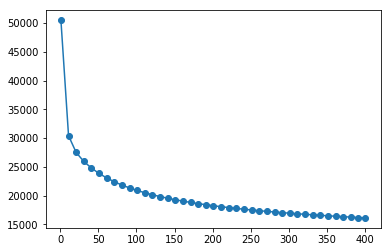

In [4]:
benchmarks = factorizer.train(steps=400, learning_rate=1e-4)
steps = [bm[0] for bm in benchmarks]
losses = [bm[1] for bm in benchmarks]
rmses = [bm[2] for bm in benchmarks]

plt.plot(steps, losses, 'o-')
plt.show()

## Root Mean Squared Error
The 100,000 ratings dataset we use is for debugging purpose. The number of ratings we have in this dataset is far too small, the RMSE error is relatively high.

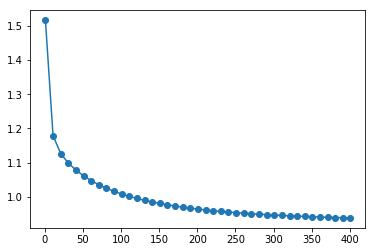

In [5]:
plt.plot(steps, rmses, 'o-')